# Spectral Curvature

## Libraries

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM, AutoModelForCausalLM
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import math
import random

## Model -- DialoGPT


In [ ]:
MODEL_NAME = "microsoft/DialoGPT-medium"  # you can switch to small/large
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.float32
EPS_DIST = 1e-12              # floor for probabilities before sqrt
EPS_CURV = 1e-12              # epsilon in the curvature denominator

PROMPT1 = "The artist drew a landscape with a river flowing towards the mountains."
PROMPT2 = "इसे आज़माने के लिए, नीचे अपनी भाषा और इनपुट उपकरण चुनें और लिखना आरंभ करें|"
PROMPT3 = "أنا ملك عالمي الخاص ولا أجرؤ على إجباري على تلبية احتياجات من اختيارك"
PROMPT4 = "श्वः अतीव द्रुतं धावति"
PROMPT6 = r"""Z = \int \mathcal{D}\phi \, \exp \left( i \int d^4x \, \sqrt{-g(x)}
\left[ \frac{1}{2} g^{\mu\nu}(x) \partial_\mu \phi(x) \, \partial_\nu \phi(x)
- \frac{1}{2} m^2 \phi^2(x)
- \frac{\lambda}{4!} \phi^4(x)
+ \frac{1}{16\pi G} (R(x) - 2\Lambda) \right] \right)"""

PROMPTS = [
    ("Simple English", PROMPT1),
    ("Simple Hindi", PROMPT2),
    ("Slightly Complicated Arabic", PROMPT3),
    ("Simple Sanskrit", PROMPT4),
    ("Complex Math Jargon", PROMPT6),
]

In [ ]:
print(f"Using device: {DEVICE}")

Using device: cuda


In [ ]:
# Load model & tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(MODEL_NAME).to(DEVICE)
model.eval()

ln_f = model.transformer.ln_f
lm_head = model.lm_head
vocab_size = model.config.vocab_size

In [ ]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50257, bias=False)
)


In [ ]:
# Geometry helpers
def sqrt_embed(q: torch.Tensor, eps: float = EPS_DIST) -> torch.Tensor:
    """
    returns u = sqrt(q) normalized to unit length (it already should be).
    """
    q = torch.clamp(q, min=eps)
    q = q / q.sum()
    u = torch.sqrt(q)
    u = u / (torch.norm(u, p=2) + 1e-30)
    return u

def project_tangent(u: torch.Tensor, v: torch.Tensor) -> torch.Tensor:
    """
    Project vector v onto the tangent space at u on the sphere
    """
    return v - torch.dot(u, v) * u

def curvature_simp(u_list, eps_curv: float = EPS_CURV):
    """
    Compute κ_ell^(simp) for ell = 1..(m-2)
    """
    m = len(u_list)
    assert m >= 3

    # First-difference speeds s_ell = ||Δu_ell|| for ell=0..m-2
    delta_u = []
    speeds = []
    for ell in range(m - 1):
        u = u_list[ell]
        v = u_list[ell + 1] - u
        du = project_tangent(u, v)
        delta_u.append(du)
        speeds.append(torch.norm(du, p=2).item())

    # Second differences at interior points (ell = 1..m-2)
    ks = []
    for ell in range(1, m - 1):
        u = u_list[ell]
        v2 = (u_list[ell + 1] - 2 * u_list[ell] + u_list[ell - 1])
        d2u = project_tangent(u, v2)
        num = torch.norm(d2u, p=2)
        s = torch.norm(delta_u[ell], p=2)
        denom = (s * s + eps_curv) ** 1.5
        k = (num / denom).item()
        ks.append(k)

    return ks, speeds

In [ ]:
# Logit-lens utilities
@torch.no_grad()
def layerwise_next_token_distributions(text: str):

    enc = tokenizer(text, return_tensors="pt", add_special_tokens=False).to(DEVICE)

    if enc.input_ids.shape[1] == 0:
        raise ValueError("Empty tokenized input.")

    out = model(**enc, output_hidden_states=True)
    hidden_states = out.hidden_states

    # We will compute the "next-token" distribution at the last position t
    t = enc.input_ids.shape[1] - 1

    q_list = []
    for h in hidden_states:
        vec = h[0, t, :]
        vec = ln_f(vec)
        logits = lm_head(vec)
        q = torch.softmax(logits.to(DTYPE), dim=-1)
        q_list.append(q)

    return q_list

In [ ]:
# Main evaluation loop
results = {}

for name, text in PROMPTS:
    print(f"\n=== Prompt: {name} ===")
    print(text)

    q_list = layerwise_next_token_distributions(text)

    u_list = [sqrt_embed(q) for q in q_list]

    k_list, s_list = curvature_simp(u_list, eps_curv=EPS_CURV)

    results[name] = {
        "curvature": np.array(k_list),
        "speeds": np.array(s_list),
        "num_nodes": len(u_list),
    }

    print(f"Layers available (including embedding): {len(u_list)}")
    print("Layer  idx (interior) |  κ^(simp) ")
    for i, k in enumerate(k_list, start=1):
        print(f"       {i:3d}         |  {k:.6e}")


=== Prompt: Simple English ===
The artist drew a landscape with a river flowing towards the mountains.
Layers available (including embedding): 25
Layer  idx (interior) |  κ^(simp) 
         1         |  1.812848e+01
         2         |  1.348271e+01
         3         |  1.884840e+01
         4         |  2.087096e+01
         5         |  8.927969e+00
         6         |  1.771181e+01
         7         |  9.555651e+00
         8         |  1.461701e+01
         9         |  6.676983e+00
        10         |  9.908180e+00
        11         |  8.683645e+00
        12         |  1.701178e+01
        13         |  1.016704e+01
        14         |  5.727136e+00
        15         |  1.482061e+01
        16         |  1.291950e+01
        17         |  1.312060e+01
        18         |  1.513223e+01
        19         |  3.322679e+01
        20         |  1.676787e+01
        21         |  9.241374e+00
        22         |  2.814230e+00
        23         |  1.097559e+00

=== Prompt: 

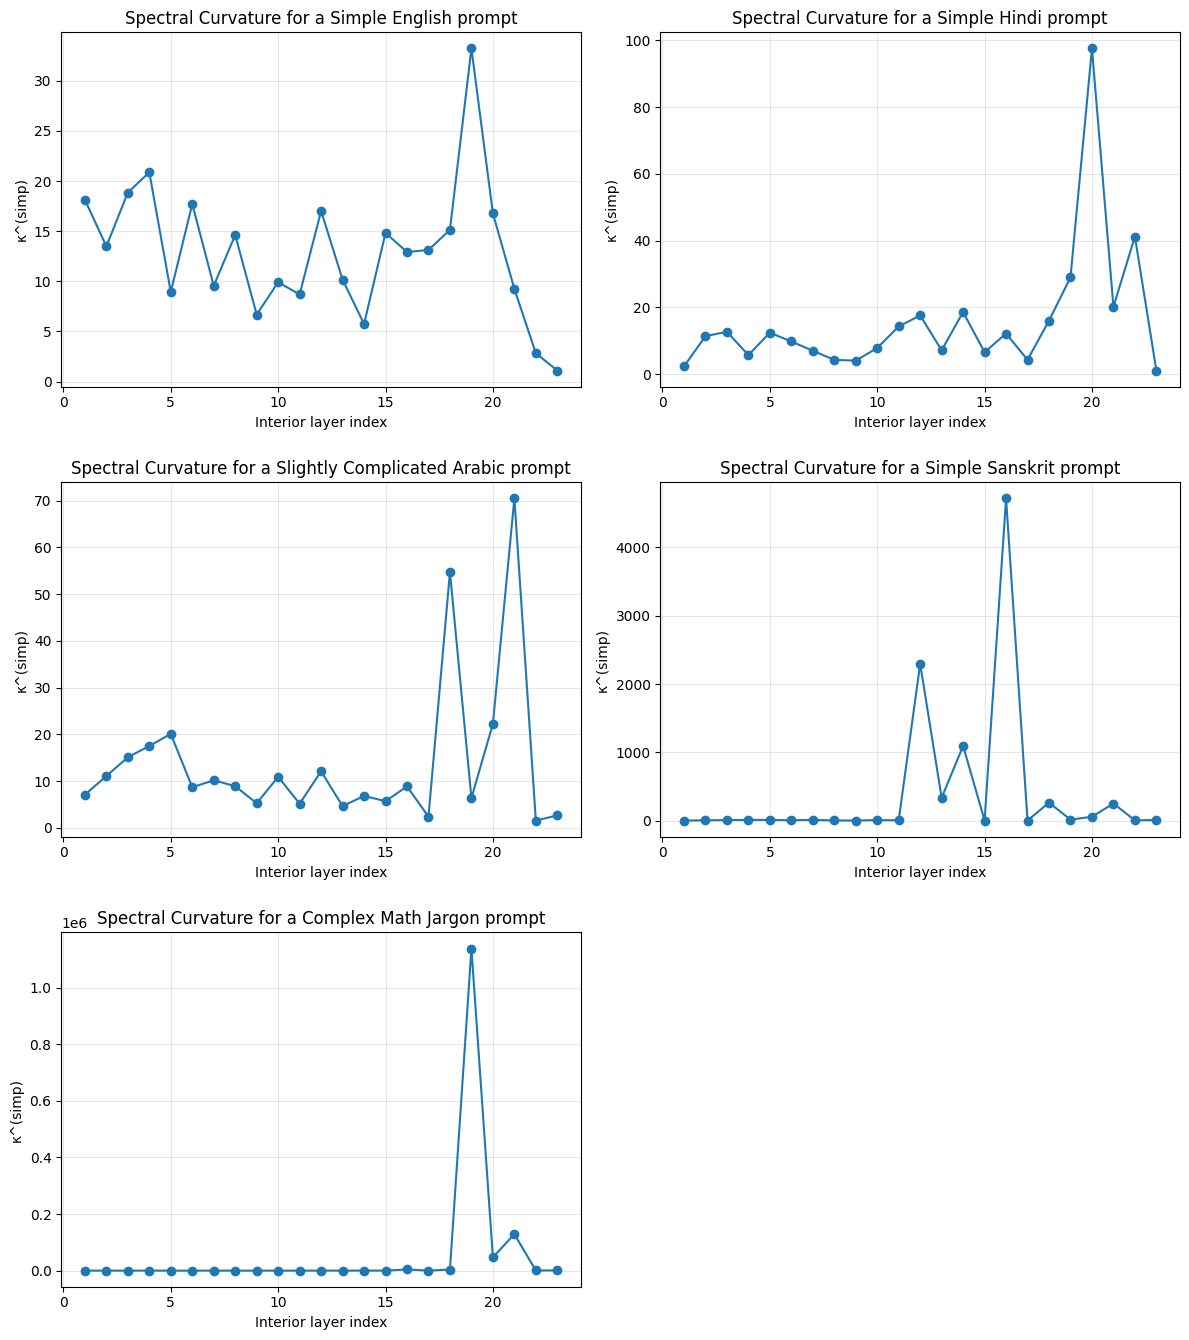

In [ ]:
# visualization

num_cols = 2
num_rows = math.ceil(len(PROMPTS) / num_cols)
plt.figure(figsize=(6 * num_cols, 4.5 * num_rows))

for idx, (name, _) in enumerate(PROMPTS, 1):
    data = results[name]["curvature"]
    m = results[name]["num_nodes"]
    xs = np.arange(1, m - 1)
    plt.subplot(num_rows, num_cols, idx)
    plt.plot(xs, data, marker='o')
    plt.title(f"Spectral Curvature for a {name} prompt")
    plt.xlabel("Interior layer index")
    plt.ylabel("κ^(simp)")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()